In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K

# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = 'data/tweaked_data_limited/images/'
epochs = 3
batch_size = 32
lr = 0.01
number_classes = 2

print('done')

done


In [10]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape,activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(number_classes, activation='softmax'))

print('done')

done


In [12]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=False,
    featurewise_std_normalization=False,
    validation_split=0.2) # set validation split
print('split data')

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data
print('training data')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data
print('validation')

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint('model.h5', save_best_only=True)],
    epochs = epochs)
print('model fit')

model.save_weights('transfer_learning_try.h5')

split data
Found 50894 images belonging to 2 classes.
training data
Found 12722 images belonging to 2 classes.
validation
Epoch 1/3
1590/1590 [==============================] - 9864s 6s/step - loss: 0.4391 - val_loss: 0.4340
Epoch 2/3
1590/1590 [==============================] - 8701s 5s/step - loss: 0.3967 - val_loss: 0.4379
Epoch 3/3
1590/1590 [==============================] - 9248s 6s/step - loss: 0.3680 - val_loss: 0.4190
model fit


In [13]:
import sklearn.metrics as metrics
import numpy as np

#REF https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# Predict classes
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    train_data_dir, # Put your path here
     target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

print('predictions')
predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

print('predictions done')
# Get ground-truth classes and class-labels
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

print('getting metrics')
# Use scikit-learn to get statistics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

Found 63616 images belonging to 2 classes.
predictions
predictions done
getting metrics
              precision    recall  f1-score   support

         cat       0.59      0.19      0.29     10823
         dog       0.85      0.97      0.91     52793

   micro avg       0.84      0.84      0.84     63616
   macro avg       0.72      0.58      0.60     63616
weighted avg       0.81      0.84      0.80     63616



In [26]:
from sklearn.metrics import confusion_matrix

class_values = list(test_data_generator.class_indices.values())

matrix = confusion_matrix(true_classes, predicted_classes,class_values)

valid_generator = ImageDataGenerator()
valid_data_generator = valid_generator.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
STEP_SIZE_VALID=valid_data_generator.samples / valid_data_generator.batch_size

temp = model.evaluate_generator(generator=valid_data_generator,steps=STEP_SIZE_VALID)

print(temp)

Found 63616 images belonging to 2 classes.
2.4347084572549744


In [27]:
print(type(temp))

<class 'numpy.float64'>


Confusion matrix, without normalization


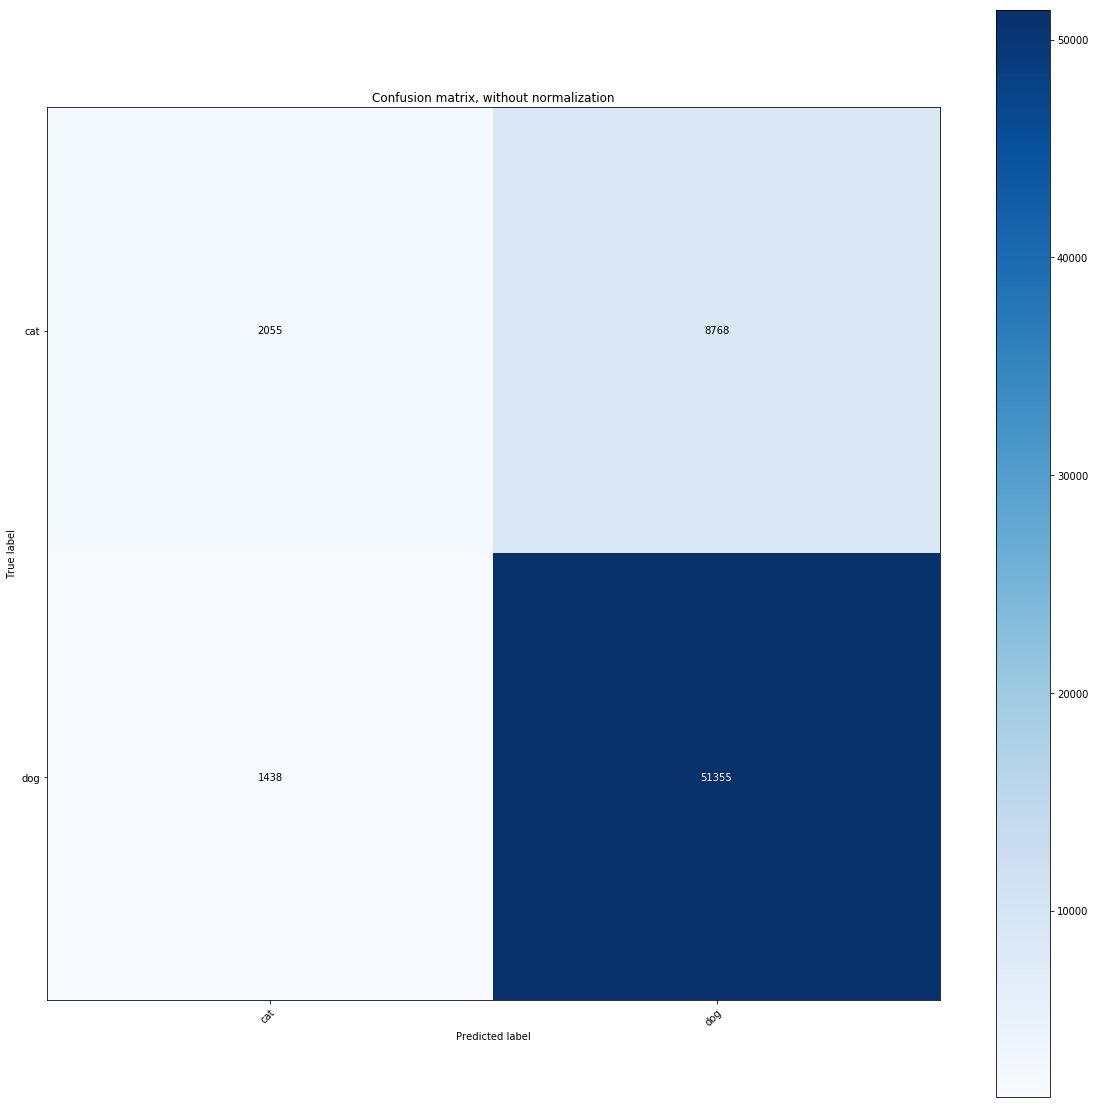

In [17]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_labels, yticklabels=class_labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

np.set_printoptions(precision=2)
t_c = unique_labels(list(test_data_generator.class_indices.values()))

# Plot non-normalized confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, classes=t_c,title='Confusion matrix, without normalization')



Normalized confusion matrix


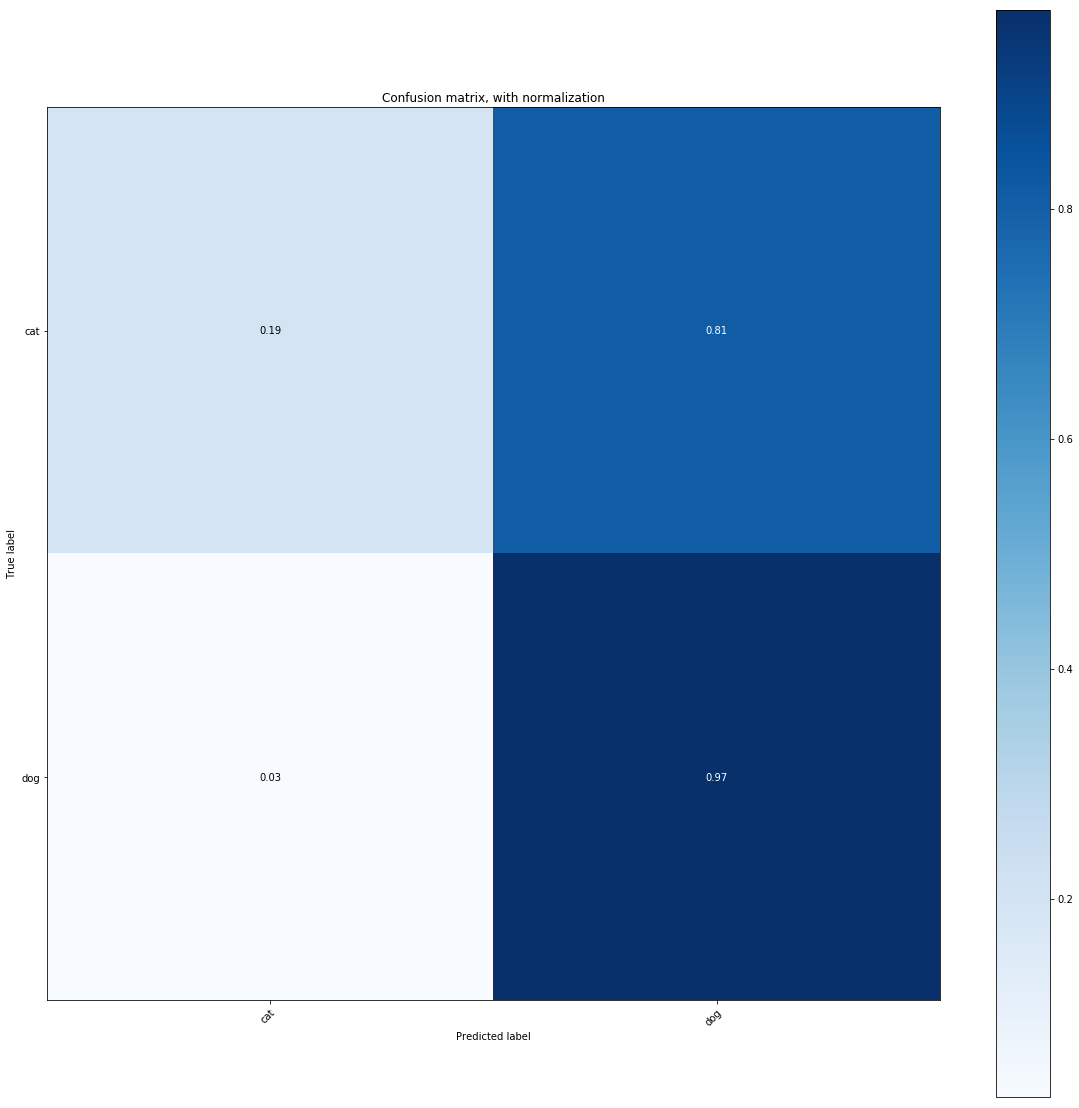

In [16]:
# Plot normalized confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, classes=t_c,normalize=True,title='Confusion matrix, with normalization')